In [79]:
# common imports
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import joblib, glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning imports


# display setup
pd.set_option("display.max_columns", None)  # the None parameter displays unlimited columns
plt.style.use('seaborn')  # for plots

# 1. Getting the Data

> Each participant has 3 csv files, one for each alignment state.
>

> Taking a look at a file should help gain insight to which DataFrame manipulations need to be implemented
> in the functions that will load the whole dataset.
>
> The 'HandRight' file contains right-hand movements which needs to be merged with the 'Alone' state files.
> Preparing it beforehand is more efficient since it will be used multiple times when loading the data.

In [80]:
# read right hand file
handright = pd.read_csv(r"extraFiles/HandRight.csv")

In [81]:
# display first 5 rows for a quick look
handright.head()

Time   Frame ID  Hand Type   # hands   Position X   Position Y  \
0  128.2883      15478      right         1     15.67167     226.2064   
1  128.3048      15480      right         1     16.24119     222.9389   
2  128.3218      15482      right         1     16.72461     220.9709   
3  128.3384      15484      right         1     17.09016     219.7124   
4  128.3551      15486      right         1     17.46017     219.3652   

    Position Z   Velocity X   Velocity Y   Velocity Z     Pitch      Roll  \
0     20.26470     34.26665  -195.214700   -35.043020  0.270987 -0.017635   
1     20.11781     36.16443  -180.093900    -4.052799  0.245085 -0.014770   
2     19.94972     26.35298   -95.088190   -11.157620  0.230796 -0.008779   
3     19.67679     19.46804   -61.755180   -21.303780  0.217681 -0.010759   
4     19.13128     21.94964    -8.355943   -35.081790  0.220696 -0.017380   

        Yaw   Wrist Pos X   Wrist Pos Y   Wrist Pos Z   Elbow pos X  \
0 -0.277800      46.88831      207.3548      86.23589      203.8337   
1 -0.277763      47.54861      205.6568      86.42250      203.9553   
2 -0.278792      48.15030      204.5182      86.35149      204.6231   
3 -0.279768      48.64175      203.9989      86.16056      204.9939   
4 -0.278629      48.93135      203.3777      85.59017      204.5952   

    Elbow Pos Y   Elbow Pos Z   Grab Strenth   Grab Angle   Pinch Strength  
0      49.33507      237.4553            0.0     0.206389              0.0  
1      47.88272      238.4482            0.0     0.243050              0.0  
2      45.35921      236.8544            0.0     0.281134              0.0  
3      44.18692      236.0927            0.0     0.277691              0.0  
4      42.68003      235.2896            0.0     0.283008              0.0

In [82]:
# DataFrame shape (rows, columns)
handright.shape

(4812, 22)

In [83]:
# description of data
handright.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             4812 non-null   float64
 1    Frame ID        4812 non-null   int64  
 2    Hand Type       4812 non-null   object 
 3    # hands         4812 non-null   int64  
 4    Position X      4812 non-null   float64
 5    Position Y      4812 non-null   float64
 6    Position Z      4812 non-null   float64
 7    Velocity X      4812 non-null   float64
 8    Velocity Y      4812 non-null   float64
 9    Velocity Z      4812 non-null   float64
 10   Pitch           4812 non-null   float64
 11   Roll            4812 non-null   float64
 12   Yaw             4812 non-null   float64
 13   Wrist Pos X     4428 non-null   float64
 14   Wrist Pos Y     4428 non-null   float64
 15   Wrist Pos Z     4428 non-null   float64
 16   Elbow pos X     4428 non-null   float64
 17   Elbow Pos Y  

In [84]:
# show null values
handright.isna().sum()

Time                 0
 Frame ID            0
 Hand Type           0
 # hands             0
 Position X          0
 Position Y          0
 Position Z          0
 Velocity X          0
 Velocity Y          0
 Velocity Z          0
 Pitch               0
 Roll                0
 Yaw                 0
 Wrist Pos X       384
 Wrist Pos Y       384
 Wrist Pos Z       384
 Elbow pos X       384
 Elbow Pos Y       384
 Elbow Pos Z       384
 Grab Strenth        0
 Grab Angle          0
 Pinch Strength      0
dtype: int64

In [85]:
# should only contain 1 hand instances
handright[" # hands"].value_counts()

1    4732
2      80
Name:  # hands, dtype: int64

In [86]:
# should only contain right hand instances
handright[" Hand Type"].value_counts()

right    4738
left       74
Name:  Hand Type, dtype: int64

> Features in the DataFrame:
1. Time: Second and milliseconds of recorded movement
2. Frame ID: Frame number of detected movement
3. Hand Type: Right or left hand
4. Number hands: Hands detected in the frame/movement
5. Position (X, Y, Z): Center position of the palm from the leap origin (in millimeters)
6. Velocity (X, Y, Z): Rate of change of the palm position (millimeters per second)
7. Pitch: The rotation around the x-axis (angle above or below the x-z plane in radians)
8. Roll: The rotation around the z-axis (angle right or left of the y-axis in radians)
9. Yaw: The rotation around the y-axis (angle right or left of the y-axis in radians)
10. Wrist Pos (X, Y, Z): Position of the wrist
11. Elbow pos (X, Y, Z): Position of the elbow
12. Grab Strength: The strength of a grab hand pose (values in range [0,1])
** Grab strength deprecated from version 2.0, use grab angle instead
13. Grab Angle: The angle between the fingers and the grab hand pose (0 to pi radians)
14. Pinch Strength: Pinch holding strength between the thumb and closest fingertip
(0 = flat open hand, (0, 1] = pinch strength increases as the tip of thumb approaches fingertip).

* X, Y, Z represent leap motion controller coordinates (see image below).

> Features in the DataFrame:
1. Time: Second and milliseconds of recorded movement
2. Frame ID: ID of the frame the hand belongs to
3. Hand Type: Right or left hand
4. Number hands: Hands detected in the frame/movement
5. Position (X, Y, Z): Center position of the palm from the leap origin (in millimeters)
6. Velocity (X, Y, Z): Rate of change of the palm position (millimeters per second)
7. Pitch: The rotation around the x-axis (angle above or below the x-z plane in radians)
8. Roll: The rotation around the z-axis (angle right or left of the y-axis in radians)
9. Yaw: The rotation around the y-axis (angle right or left of the y-axis in radians)
10. Wrist Pos (X, Y, Z): Position of the wrist
11. Elbow pos (X, Y, Z): Position of the elbow
12. Grab Strength: The grab posture rating of the hand
13. Grab Angle: The average angle of the fingers to the hand
14. Pinch Strength: Pinch holding strength between the thumb and closest fingertip
(0 = flat open hand, (0, 1] = pinch strength increases as the tip of thumb approaches fingertip).

* X, Y, Z represent leap motion controller coordinates (see image below).

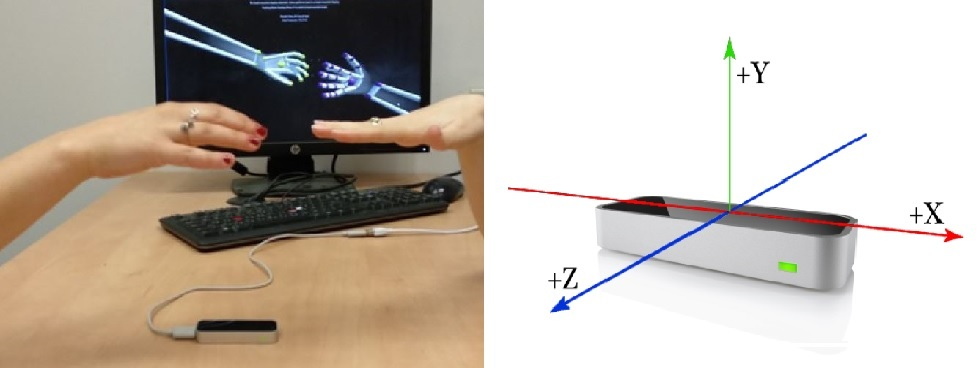

In [87]:
from IPython import display
display.Image("extraFiles/leap.jpg")

Clearly just by looking at a few files the data needs to be cleaned.

* Alone has instances with 2 hands and right hand in hand type that need to be removed. Likewise, spontaneous
and sync have instances with 1 hand and a mismatch between right and left hands.

In [88]:
def remove_first7(df):
    df.drop(df[df["Time"] < df["Time"].min() + 7].index, inplace=True)
    # drop is True to prevent from adding the old indices as a new column
    df.reset_index(drop=True, inplace=True)

In [89]:
print("Before:", handright.shape)
handright_prepared = handright.drop(handright[(handright[" Hand Type"] == "left") | (handright[" # hands"] == 2)].index)
handright_prepared.reset_index(drop=True, inplace=True)
remove_first7(handright_prepared)  # right hand file without first 7 seconds

Before: (4812, 22)


In [90]:
print("Null values:", handright_prepared.isna().sum().sum())
handright_prepared[handright_prepared.isna().any(axis=1)].head()

Null values: 2304


Time   Frame ID  Hand Type   # hands   Position X   Position Y  \
3893  201.8797      23959      right         1    -8.565041     140.3621   
3894  201.8968      23962      right         1     1.858126     112.7275   
3895  201.9134      23963      right         1     2.825271     112.5456   
3896  201.9300      23965      right         1     3.694190     113.4331   
3897  201.9464      23967      right         1     5.272612     115.7207   

       Position Z   Velocity X   Velocity Y   Velocity Z     Pitch      Roll  \
3893    112.05200     32.42480   -145.06130    -160.3878  1.188079 -2.793904   
3894     95.47443    497.33780   -642.50110    -686.8898  0.144945  0.010979   
3895     91.11944    112.62890    -21.18921    -507.1606  0.143836 -0.002969   
3896     82.37254     61.92186     95.66204    -499.7987  0.157899 -0.025162   
3897     73.13319    107.58490    139.81950    -569.6603  0.149520 -0.008641   

           Yaw   Wrist Pos X   Wrist Pos Y   Wrist Pos Z   Elbow pos X  \
3893 -0.139680           NaN           NaN           NaN           NaN   
3894  0.038722           NaN           NaN           NaN           NaN   
3895  0.067269           NaN           NaN           NaN           NaN   
3896  0.093537           NaN           NaN           NaN           NaN   
3897  0.075155           NaN           NaN           NaN           NaN   

       Elbow Pos Y   Elbow Pos Z   Grab Strenth   Grab Angle   Pinch Strength  
3893           NaN           NaN            0.0     0.000000              0.0  
3894           NaN           NaN            0.0     0.418411              0.0  
3895           NaN           NaN            0.0     0.379807              0.0  
3896           NaN           NaN            0.0     0.523864              0.0  
3897           NaN           NaN            0.0     0.715370              0.0

In [91]:
handright_prepared.dropna(inplace=True)
print("Null values:", handright_prepared.isna().sum().sum())
print("After:", handright_prepared.shape)
handright_prepared.head()

Null values: 0
After: (3893, 22)


Time   Frame ID  Hand Type   # hands   Position X   Position Y  \
0  135.3024      16287      right         1     11.93032     199.9861   
1  135.3194      16289      right         1     11.19190     195.3075   
2  135.3357      16291      right         1     10.53308     189.0297   
3  135.3524      16293      right         1     10.24300     181.9816   
4  135.3690      16295      right         1     10.02061     174.8592   

    Position Z   Velocity X   Velocity Y   Velocity Z     Pitch      Roll  \
0     4.981665   -35.512210    -165.3466    -57.68153 -0.092033  0.108262   
1     3.661716   -43.587440    -309.8374    -77.18515 -0.111674  0.126925   
2     2.829388   -30.403600    -363.0033    -43.79815 -0.140004  0.127219   
3     2.064330   -15.424000    -423.2120    -43.99948 -0.166623  0.122782   
4     1.228467    -8.733602    -413.4513    -53.88054 -0.197763  0.127587   

        Yaw   Wrist Pos X   Wrist Pos Y   Wrist Pos Z   Elbow pos X  \
0 -0.906612      75.45740      206.0521      45.38764      284.3946   
1 -0.904311      74.46141      202.4562      44.28679      282.6278   
2 -0.901862      73.60060      197.4387      43.54082      280.6384   
3 -0.901268      73.19537      191.7202      42.73155      279.7357   
4 -0.897777      72.68671      186.1613      41.98006      278.6890   

    Elbow Pos Y   Elbow Pos Z   Grab Strenth   Grab Angle   Pinch Strength  
0      140.0167      201.9318            0.0     0.561324              0.0  
1      140.9712      203.6773            0.0     0.626321              0.0  
2      142.5401      206.7526            0.0     0.636596              0.0  
3      148.1382      209.9330            0.0     0.701644              0.0  
4      152.5215      212.1112            0.0     0.786548              0.0

In [92]:
# split right hand file for training and testing
# train_size = round(len(handright_prepared) * 0.8)
# print(train_size)

# handright_prepared_train = handright_prepared.loc[:train_size].copy()
# handright_prepared_test = handright_prepared.loc[train_size:].copy()

# print("Right Hand Train\nShape:", handright_prepared_train.shape,
#      "\nNull Values:", handright_prepared_train.isna().sum().sum())
# print()
# print("Right Hand Test\nShape:", handright_prepared_test.shape,
#      "\nNull Values:", handright_prepared_test.isna().sum().sum())

> The following functions load the data into a DataFrame:

In [93]:
# function combines alone csv file with the right hand file

def combine_right(df_alone):
    # remove instances with right hand or 2 hands
    df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
    df_alone.reset_index(drop=True, inplace=True)

    # copy of right hand prevents harming the DataFrame since it is used multiple times
    right = handright_prepared.copy()

    # calculate number of copies needed to match length of left hand
    n_copies = round(len(df_alone) / len(right)) + 1
    copies = []  # list for appending copies
    for i in range(n_copies):
        copies.append(right)
    right = pd.concat(copies, axis=0, ignore_index=True)  # concat DataFrame copies
    right = right.loc[:len(df_alone) - 1]  # -1 since loc includes the end index and dataframe indices start from 0

    # align column values with alone
    right.Time = df_alone.Time
    right[" Frame ID"] = df_alone[" Frame ID"]

    # merge DataFrames, sort by Time column and reset index
    merged = right.merge(df_alone, how="outer").sort_values("Time").reset_index(drop=True)
    merged[" # hands"] = 2  # change number of hands to 2 (2 hand rows were dropped per dataframe before merge)
    return merged

In [94]:
# function returns a DataFrame with right and left hands merged into one row
# column names format is changed

def transform_columns(df):
    # strip removes white spaces in the beginning and end
    # lower changes uppercase letters to lowercase
    df.columns = df.columns.str.strip().str.lower()
    # rename columns without spaces
    df.columns = df.columns.str.replace(" ", "_")
    # change number of hands column name
    df.columns = df.columns.str.replace("#_hands", "n_hands")
    df.columns = df.columns.str.replace("grab_strenth", "grab_strength")

    # remove instances with 1 hand detected
    df.drop(df[df["n_hands"] == 1].index, inplace=True)

    # merge right and left hands into one row
    left = df.groupby("hand_type").get_group("left").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    right = df.groupby("hand_type").get_group("right").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    keep_same = {"state", "time"}  # shared columns
    left.columns = left.columns.map(lambda x: x if x in keep_same else x + "_left")
    right.columns = right.columns.map(lambda x: x if x in keep_same else x + "_right")
    merged = left.merge(right, how="outer", on=["state", "time"])
    # adds a column with the second
    merged.insert(1, "round_time", merged.time.astype(int) - merged.time.min().astype(int))
    # return first 5 frames per second
    return merged.groupby("round_time").nth([0, 1, 2, 3, 4]).reset_index(drop=True) # round time is the index after groupby

In [95]:
train_path = "extraFiles/Training/**/*.csv"
test_path = "extraFiles/Validation/**/*.csv"


def load_data(path, as_pandas):
    data = []
    # glob searches all directories and files
    for filename in glob.iglob(path, recursive=True):
        df = pd.read_csv(filename, index_col=None, header=0)
        remove_first7(df)  # removes first 7 seconds from file
        if "Alone" in filename:
            df = combine_right(df)
            df.insert(0, "state", 0)
        elif "Spontan" in filename:
            df.insert(0, "state", 1)
        elif "Sync" in filename:
            df.insert(0, "state", 2)
        df = transform_columns(df)
        data.append(df)
    if as_pandas:
        return pd.concat(data, axis=0, ignore_index=True)
    return data

In [96]:
# load the data
train_set = load_data(train_path, as_pandas=True)
test_set = load_data(test_path, as_pandas=True)

In [97]:
# display loaded data
train_set.head()

state      time  position_x_left  position_y_left  position_z_left  \
0      1  343.0061        -102.2870         198.3166        -2.122641   
1      1  343.0227        -103.8721         201.4944        -2.063620   
2      1  343.0392        -106.3691         207.4667        -2.337110   
3      1  343.0558        -107.9509         212.1324        -2.788956   
4      1  343.0723        -109.5427         216.8003        -3.337280   

   velocity_x_left  velocity_y_left  velocity_z_left  pitch_left  roll_left  \
0       -174.57210         379.1468        28.479910    1.423625   0.510471   
1       -178.50250         357.8548         6.646493    1.429039   0.500107   
2       -126.78780         318.5284       -12.872290    1.441357   0.489946   
3        -74.28078         244.4823       -30.771300    1.444497   0.483316   
4        -96.49666         269.5434       -37.723870    1.431969   0.488396   

   yaw_left  wrist_pos_x_left  wrist_pos_y_left  wrist_pos_z_left  \
0  1.481006         -164.0542          164.5314         -1.686393   
1  1.486744         -165.7898          168.1620         -2.054844   
2  1.496526         -168.4939          174.6985         -3.134404   
3  1.499930         -170.1878          179.6781         -4.185746   
4  1.491886         -171.4205          183.7144         -4.797314   

   elbow_pos_x_left  elbow_pos_y_left  elbow_pos_z_left  grab_strength_left  \
0         -322.2086         -30.71549         11.754400                 0.0   
1         -318.4708         -31.61653          7.529989                 0.0   
2         -316.4541         -28.81729         -1.155143                 0.0   
3         -315.3597         -25.78214         -9.287997                 0.0   
4         -311.4874         -25.01130        -16.183130                 0.0   

   grab_angle_left  pinch_strength_left  position_x_right  position_y_right  \
0         1.870325                  0.0          152.3135          204.6813   
1         1.851572                  0.0          151.8334          204.4899   
2         1.865896                  0.0          151.4056          203.4883   
3         1.899355                  0.0          151.6132          202.9217   
4         1.950082                  0.0          152.4920          202.8671   

   position_z_right  velocity_x_right  velocity_y_right  velocity_z_right  \
0         -39.25671         -28.56766         23.006620          8.315823   
1         -39.08438         -54.05849        -21.545550         19.405560   
2         -38.14280         -14.11075        -56.448120         68.092860   
3         -37.08601          21.48209        -21.234860         51.146260   
4         -36.85715          57.06179          4.746809         17.712610   

   pitch_right  roll_right  yaw_right  wrist_pos_x_right  wrist_pos_y_right  \
0     0.654996   -0.130873  -0.563396           191.4088           170.3479   
1     0.652891   -0.134715  -0.560823           190.8670           170.1528   
2     0.637780   -0.134837  -0.554623           190.4547           169.7302   
3     0.608950   -0.142477  -0.548808           190.8024           170.2935   
4     0.568949   -0.165198  -0.553877           192.5801           172.1215   

   wrist_pos_z_right  elbow_pos_x_right  elbow_pos_y_right  elbow_pos_z_right  \
0           8.976357           323.5327           21.27053           162.7099   
1           9.191355           323.1941           20.16283           161.8589   
2          10.512530           324.1130           19.09524           161.3746   
3          12.170700           323.0928           17.14600           161.7030   
4          12.837430           325.7650           19.51061           162.1241   

   grab_strength_right  grab_angle_right  pinch_strength_right  
0             1.000000          2.793122              0.329752  
1             1.000000          2.704073              0.293775  
2             1.000000          2.422549              0.175940  
3             1.000000          2.10140

# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [98]:
hands = train_set.copy()

In [99]:
hands.head(2)

state      time  position_x_left  position_y_left  position_z_left  \
0      1  343.0061        -102.2870         198.3166        -2.122641   
1      1  343.0227        -103.8721         201.4944        -2.063620   

   velocity_x_left  velocity_y_left  velocity_z_left  pitch_left  roll_left  \
0        -174.5721         379.1468        28.479910    1.423625   0.510471   
1        -178.5025         357.8548         6.646493    1.429039   0.500107   

   yaw_left  wrist_pos_x_left  wrist_pos_y_left  wrist_pos_z_left  \
0  1.481006         -164.0542          164.5314         -1.686393   
1  1.486744         -165.7898          168.1620         -2.054844   

   elbow_pos_x_left  elbow_pos_y_left  elbow_pos_z_left  grab_strength_left  \
0         -322.2086         -30.71549         11.754400                 0.0   
1         -318.4708         -31.61653          7.529989                 0.0   

   grab_angle_left  pinch_strength_left  position_x_right  position_y_right  \
0         1.870325                  0.0          152.3135          204.6813   
1         1.851572                  0.0          151.8334          204.4899   

   position_z_right  velocity_x_right  velocity_y_right  velocity_z_right  \
0         -39.25671         -28.56766          23.00662          8.315823   
1         -39.08438         -54.05849         -21.54555         19.405560   

   pitch_right  roll_right  yaw_right  wrist_pos_x_right  wrist_pos_y_right  \
0     0.654996   -0.130873  -0.563396           191.4088           170.3479   
1     0.652891   -0.134715  -0.560823           190.8670           170.1528   

   wrist_pos_z_right  elbow_pos_x_right  elbow_pos_y_right  elbow_pos_z_right  \
0           8.976357           323.5327           21.27053           162.7099   
1           9.191355           323.1941           20.16283           161.8589   

   grab_strength_right  grab_angle_right  pinch_strength_right  
0                  1.0          2.793122              0.329752  
1                  1.0          2.704073              0.293775

In [100]:
hands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9178 entries, 0 to 9177
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state                 9178 non-null   int64  
 1   time                  9178 non-null   float64
 2   position_x_left       9178 non-null   float64
 3   position_y_left       9178 non-null   float64
 4   position_z_left       9178 non-null   float64
 5   velocity_x_left       9178 non-null   float64
 6   velocity_y_left       9178 non-null   float64
 7   velocity_z_left       9178 non-null   float64
 8   pitch_left            9178 non-null   float64
 9   roll_left             9178 non-null   float64
 10  yaw_left              9178 non-null   float64
 11  wrist_pos_x_left      9178 non-null   float64
 12  wrist_pos_y_left      9178 non-null   float64
 13  wrist_pos_z_left      9178 non-null   float64
 14  elbow_pos_x_left      9178 non-null   float64
 15  elbow_pos_y_left     

In [101]:
hands.isna().sum().sum()

0

In [102]:
hands.describe()

state         time  position_x_left  position_y_left  \
count  9178.000000  9178.000000      9178.000000      9178.000000   
mean      1.000436   540.904154      -108.309485       204.987801   
std       0.815829   143.892276        52.200750        53.756587   
min       0.000000   182.549200      -298.737100        66.096880   
25%       0.000000   435.034300      -136.126825       167.901125   
50%       1.000000   541.045550      -103.085750       202.030050   
75%       2.000000   644.050175       -76.592148       235.285100   
max       2.000000   856.163300        72.977780       478.120900   

       position_z_left  velocity_x_left  velocity_y_left  velocity_z_left  \
count      9178.000000      9178.000000      9178.000000      9178.000000   
mean         32.200270        -3.347259         0.496000         0.063305   
std          55.012932       145.355979       214.508982       131.119334   
min        -157.595300     -1313.637000     -2354.559000     -1097.682000   
25%           0.972391       -68.835925       -96.721582       -55.137282   
50%          31.225125        -4.523856         5.382333         2.242669   
75%          64.380782        59.442620       107.944650        58.657162   
max         264.220200      1814.025000      1142.433000      1660.932000   

        pitch_left    roll_left     yaw_left  wrist_pos_x_left  \
count  9178.000000  9178.000000  9178.000000       9178.000000   
mean      0.991908     0.756315     1.084286       -149.844739   
std       0.939140     1.118846     0.879691         48.365396   
min      -3.140563    -3.140818    -3.140881       -335.610400   
25%       0.651558     0.254952     0.733505       -176.421325   
50%       1.231009     0.913137     1.243266       -145.537000   
75%       1.582799     1.380014     1.586228       -116.120175   
max       3.138985     3.138921     3.139075         18.670390   

       wrist_pos_y_left  wrist_pos_z_left  elbow_pos_x_left  elbow_pos_y_left  \
count       9178.000000       9178.000000       9178.000000       9178.000000   
mean         165.997731         40.945346       -313.832137          5.663559   
std           49.367698         47.606455         61.100469         69.418601   
min            3.553310       -117.151100       -512.740700       -188.209000   
25%          133.378875         13.686630       -354.698200        -41.316207   
50%          160.962850         39.495970       -313.214100         -2.290812   
75%          189.952700         65.798150       -276.107425         39.647082   
max          438.209700        248.084500        -23.668370        377.966400   

       elbow_pos_z_left  grab_strength_left  grab_angle_left  \
count       9178.000000         9178.000000      9178.000000   
mean          75.810858            0.124499         0.835585   
std           64.597990            0.290326         0.925491   
min         -102.684900            0.000000         0.000000   
25%           27.009995            0.000000         0.000000   
50%           75.672715            0.000000         0.528428   
75%          124.904625            0.000000         1.314505   
max          343.462200            1.000000         3.141593   

       pinch_strength_left  position_x_right  position_y_right  \
count          9178.000000       9178.000000       9178.000000   
mean              0.191928         92.724502        214.957965   
std               0.332978         65.769578         55.141745   
min               0.000000       -180.878400         59.404940   
25%               0.000000         32.079682        179.581975   
50%               0.000000        112.165900        211.484100   
75%               0.278412        143.805725        246.725075   
max               1.000000        269.368900        434.498400   

       position_z_right  velocity_x_right  velocity_y_right  velocity_z_right  \
count       9178.000000       9178.000000       9178.000000       9178.000000   
mean          39.525572         -3.337

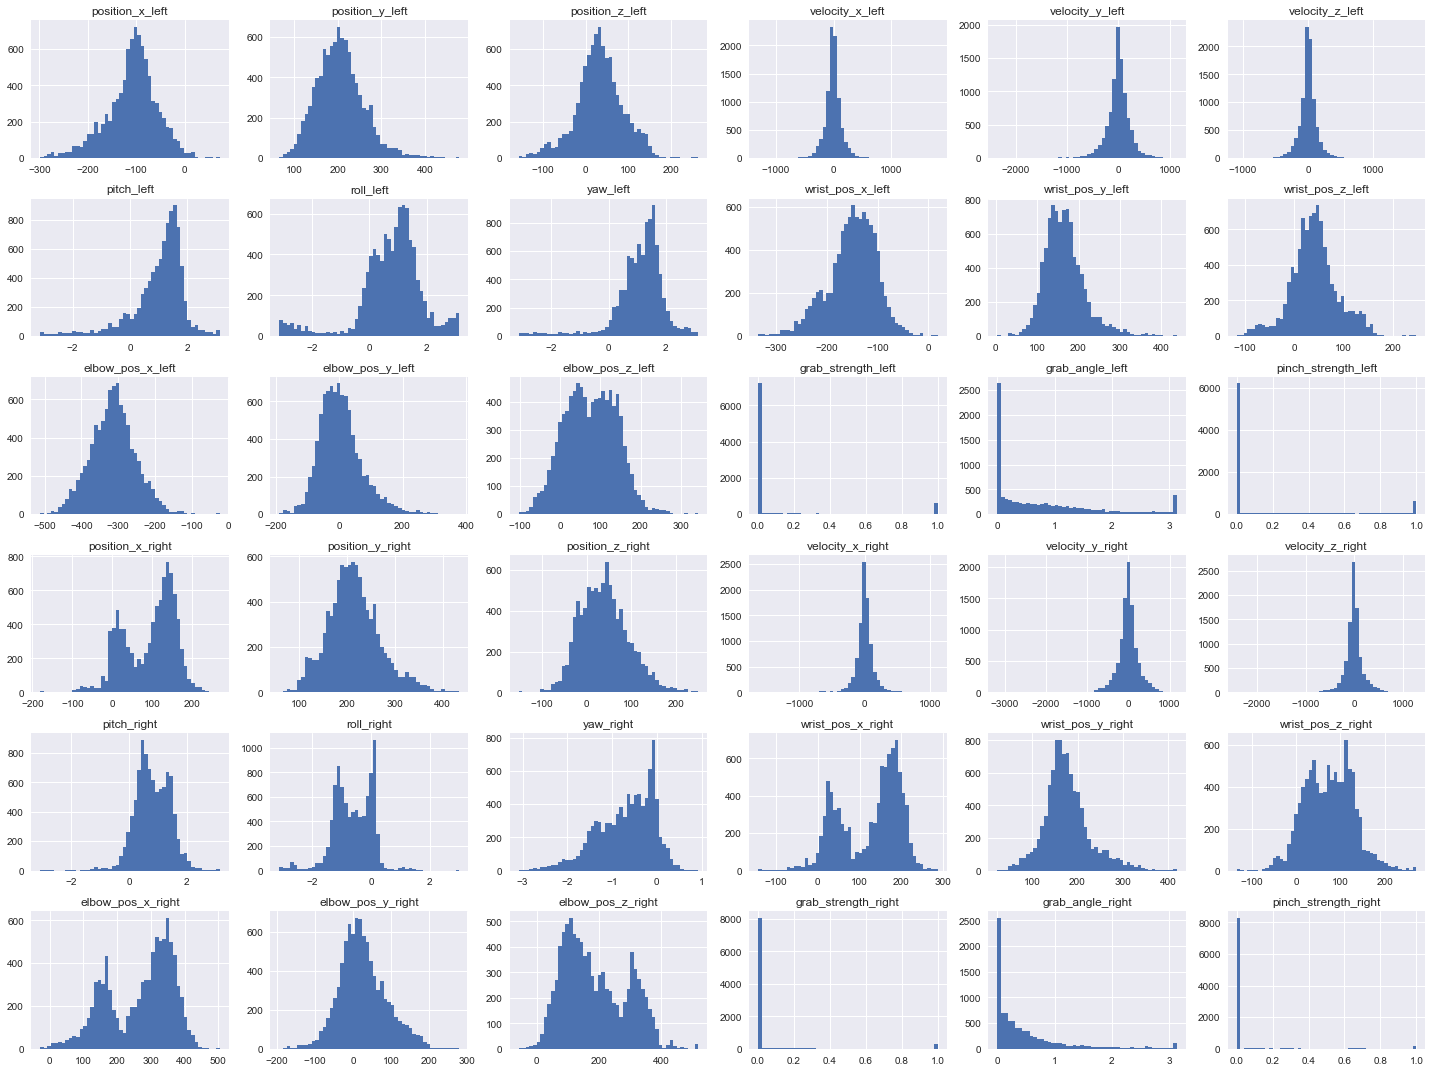

In [103]:
hands.drop(["state", "time"], axis=1, inplace=False).hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

> Initial observations from the histograms:
1. The attributes have different scales. Some values are between 0-1, while others are in the range of hundreds or
even thousands and contain negative values.
2. Most of the attributes have a relatively normal distribution. Some are a bit tail-heavy (extend farther to the
left or right).

> ### Looking for Correlations:
> Correlations measure the linear relationships between the features.
> A strong positive correlation is close to 1 and a strong negative correlation is close to -1.
> Looking for correlations with the 'state' column can emphasize which features are most significant.

left right per state

In [104]:
corr_matrix = hands.corr()

In [105]:
corr_matrix["state"].sort_values(ascending=False)

state                   1.000000
elbow_pos_x_right       0.697873
wrist_pos_x_right       0.638654
position_x_right        0.596378
pitch_right             0.443858
roll_left               0.220768
pitch_left              0.158856
time                    0.158131
position_z_left         0.135133
position_y_right        0.134826
wrist_pos_z_left        0.120733
position_y_left         0.051898
velocity_y_right        0.022784
grab_strength_right     0.022022
velocity_z_left         0.009091
velocity_x_right        0.006140
velocity_y_left         0.003244
velocity_x_left        -0.001158
velocity_z_right       -0.011938
wrist_pos_y_right      -0.016317
position_z_right       -0.031522
elbow_pos_z_left       -0.035144
yaw_left               -0.036122
pinch_strength_right   -0.064689
elbow_pos_x_left       -0.083043
wrist_pos_y_left       -0.099460
grab_strength_left     -0.108865
pinch_strength_left    -0.131348
grab_angle_right       -0.153511
wrist_pos_x_left       -0.210830
grab_angle

> Observations:
* From looking at the values, clearly the right hand has a greater influence than the left.
An assumption can be made that using the same right-hand data for all the 'alone' state files had an influence
on the right-hand correlations.
* Velocity has a low correlation for both hands and all three planes.
* Pinch and grab strength

In [118]:
cols = []
for i in range(1, len(corr_matrix["state"].values)):
    if abs(corr_matrix["state"].values[i]) >= 0.1:
        cols.append(corr_matrix["state"].index[i])
cols

['time',
 'position_x_left',
 'position_z_left',
 'pitch_left',
 'roll_left',
 'wrist_pos_x_left',
 'wrist_pos_z_left',
 'elbow_pos_y_left',
 'grab_strength_left',
 'grab_angle_left',
 'pinch_strength_left',
 'position_x_right',
 'position_y_right',
 'pitch_right',
 'roll_right',
 'yaw_right',
 'wrist_pos_x_right',
 'wrist_pos_z_right',
 'elbow_pos_x_right',
 'elbow_pos_y_right',
 'elbow_pos_z_right',
 'grab_angle_right']

In [122]:
x_cols = [col for col in hands.columns if "_x_" in col]
y_cols = [col for col in hands.columns if "_y_" in col]
z_cols = [col for col in hands.columns if "_z_" in col]
pos_cols = [col for col in hands.columns if "pos" in col]

left_cols = [col for col in cols if "_left" in col]
right_cols = [col for col in hands.columns if "_right" in col]
left_cols

['position_x_left',
 'position_z_left',
 'pitch_left',
 'roll_left',
 'wrist_pos_x_left',
 'wrist_pos_z_left',
 'elbow_pos_y_left',
 'grab_strength_left',
 'grab_angle_left',
 'pinch_strength_left']

In [120]:
state_groups = hands.groupby("state")

> ### Evaluating Feature Combinations

> #### Combining position and wrist pos columns (by plane and hand type):

In [221]:
pos_cols = hands.filter(regex="wrist_pos|position").columns.tolist()
pos_cols

['position_x_left',
 'position_y_left',
 'position_z_left',
 'wrist_pos_x_left',
 'wrist_pos_y_left',
 'wrist_pos_z_left',
 'position_x_right',
 'position_y_right',
 'position_z_right',
 'wrist_pos_x_right',
 'wrist_pos_y_right',
 'wrist_pos_z_right']

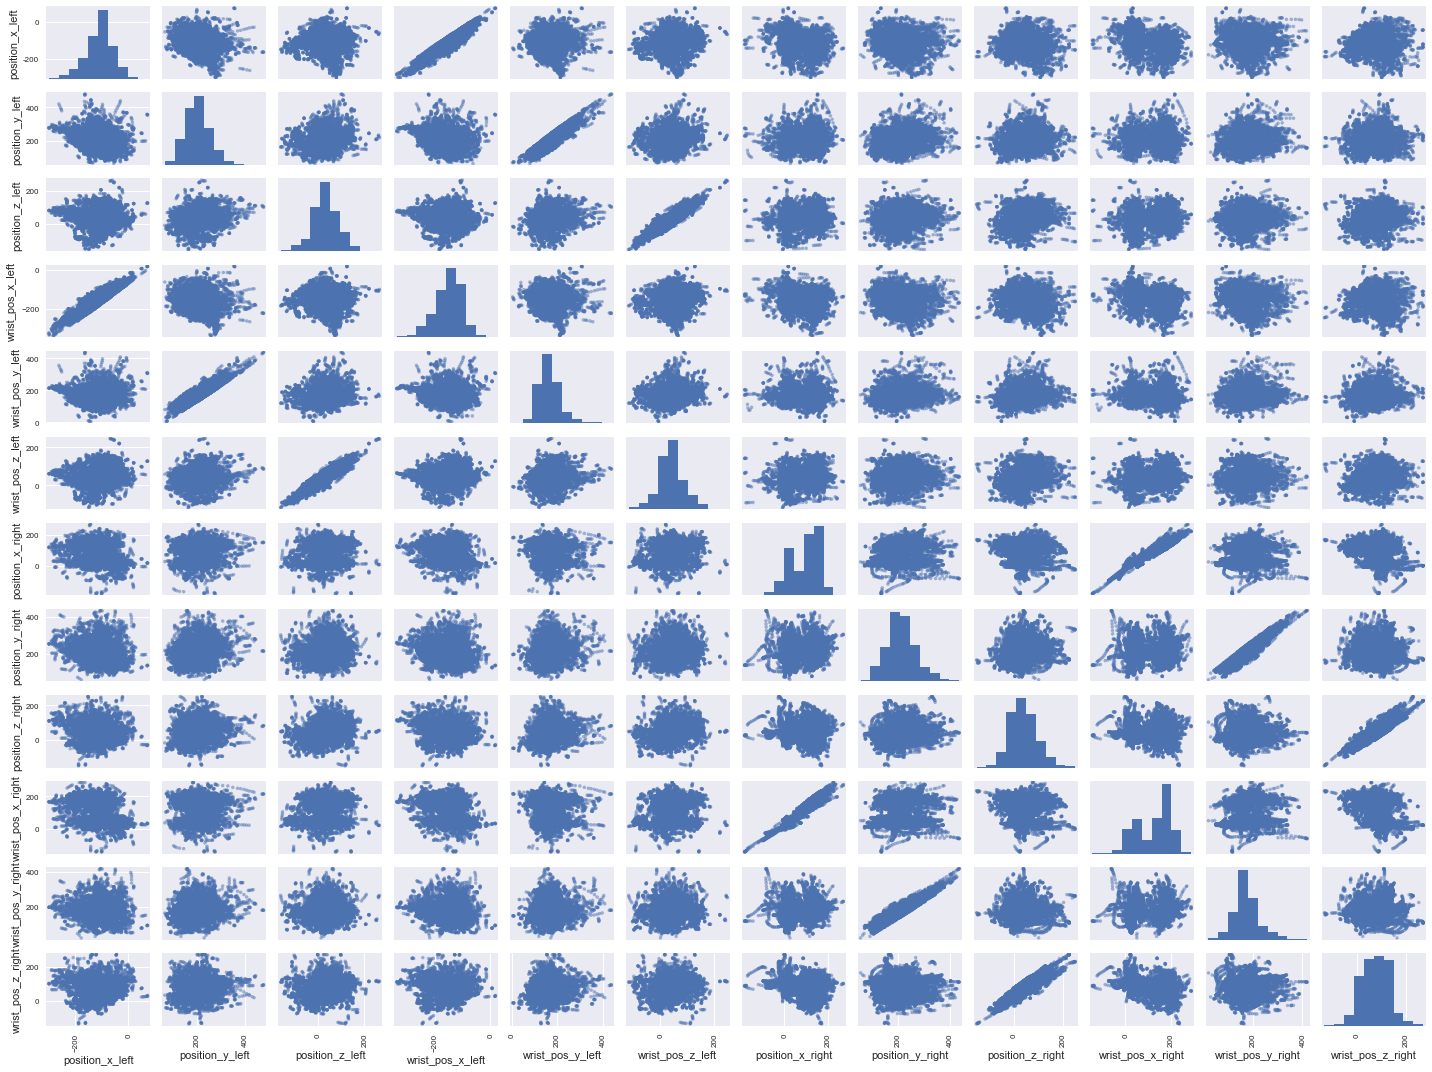

In [222]:
scatter_matrix(hands[pos_cols], figsize=(20, 15))
plt.tight_layout()
plt.show()

In [223]:
hands["mean_pos_x_left"] = (hands["wrist_pos_x_left"] + hands["position_x_left"]) / 2
hands["mean_pos_y_left"] = (hands["wrist_pos_y_left"] + hands["position_y_left"]) / 2
hands["mean_pos_z_left"] = (hands["wrist_pos_z_left"] + hands["position_z_left"]) / 2

hands["mean_pos_x_right"] = (hands["wrist_pos_x_right"] + hands["position_x_right"]) / 2
hands["mean_pos_y_right"] = (hands["wrist_pos_y_right"] + hands["position_y_right"]) / 2
hands["mean_pos_z_right"] = (hands["wrist_pos_z_right"] + hands["position_z_right"]) / 2

In [224]:
pos_cols = hands.filter(regex="wrist_pos|position|mean_pos").columns.tolist()

In [225]:
corr_matrix = hands.corr()

In [226]:
corr_matrix["state"][pos_cols].sort_values(ascending=False)

wrist_pos_x_right    0.638654
mean_pos_x_right     0.623039
position_x_right     0.596378
position_z_left      0.135133
position_y_right     0.134826
mean_pos_z_left      0.131534
wrist_pos_z_left     0.120733
mean_pos_y_right     0.063620
position_y_left      0.051898
wrist_pos_y_right   -0.016317
mean_pos_y_left     -0.021189
position_z_right    -0.031522
wrist_pos_y_left    -0.099460
mean_pos_z_right    -0.209915
wrist_pos_x_left    -0.210830
mean_pos_x_left     -0.266161
position_x_left     -0.306440
wrist_pos_z_right   -0.374024
Name: state, dtype: float64

> Overall, it seems that the new columns represent the correlation well.
> It will be useful to implement a transformer for this to easily evaluate the results during model training,
> since combining every matching wrist and position column into one also reduces dimensionality.

In [208]:
hands.groupby("state").agg(["mean", "std"])[pos_cols]

position_x_left            position_y_left            position_z_left  \
                 mean        std            mean        std            mean   
state                                                                         
0          -83.494668  54.019112      205.292998  50.258806       19.297784   
1         -118.637416  42.124747      197.577352  55.920705       39.724415   
2         -122.716579  50.582566      212.127402  53.947186       37.527254   

                 wrist_pos_x_left            wrist_pos_y_left             \
             std             mean        std             mean        std   
state                                                                      
0      62.587192      -129.770178  45.787959       173.094212  48.148373   
1      49.337008      -164.891104  42.669745       163.862299  49.368134   
2      49.822136      -154.777729  49.492835       161.055752  49.780977   

      wrist_pos_z_left            position_x_right             \
                  mean        std             mean        std   
state                                                           
0            29.166523  54.895905        19.767813  48.234953   
1            50.347954  43.161669       142.127297  25.322020   
2            43.263070  41.159730       115.956583  41.427265   

      position_y_right            position_z_right             \
                  mean        std             mean        std   
state                                                           
0           204.243329  62.676376        44.167357  45.650846   
1           218.130869  50.980984        34.524661  61.534243   
2           222.471139  49.176722        39.913682  56.177225   

      wrist_pos_x_right            wrist_pos_y_right             \
                   mean        std              mean        std   
state                                                             
0             36.869996  40.823284        174.810149  61.457885   
1            185.150377  24.197450        182.033489  44.536567   
2            152.122353  43.395381        172.780538  44.141505   

      wrist_pos_z_right             
                   mean        std  
state                               
0            106.094124  45.408531  
1             60.110667  53.801553  
2             55.626338  50.689279

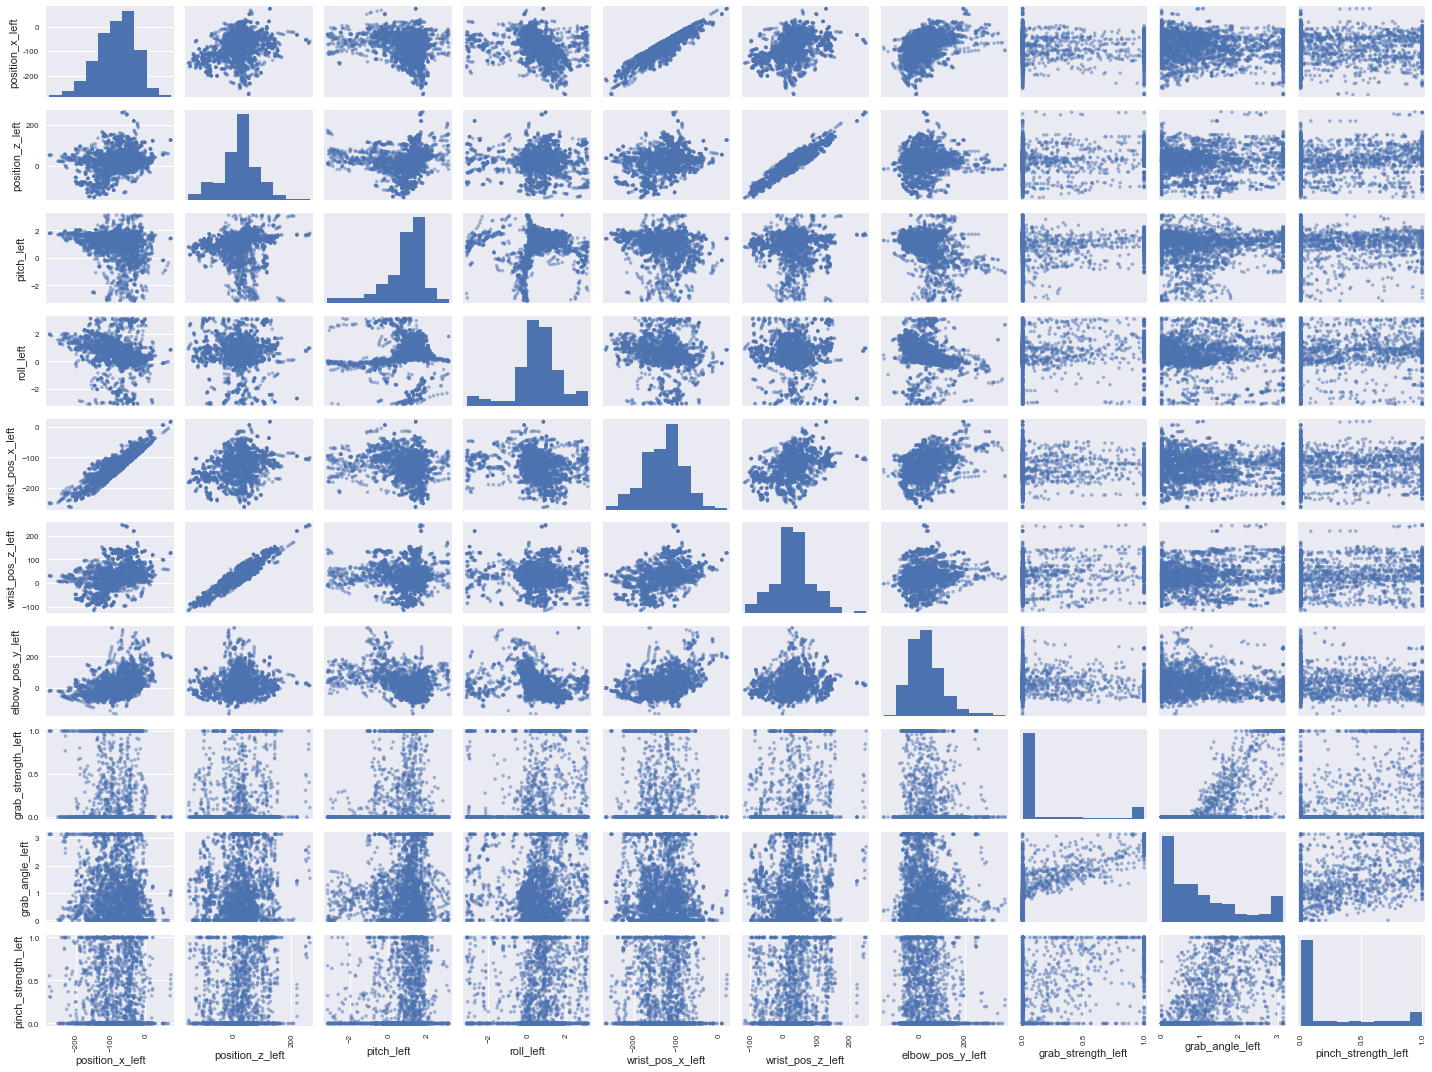

In [121]:
scatter_matrix(state_groups.get_group(0)[left_cols], figsize=(20, 15))
plt.tight_layout()
plt.show()

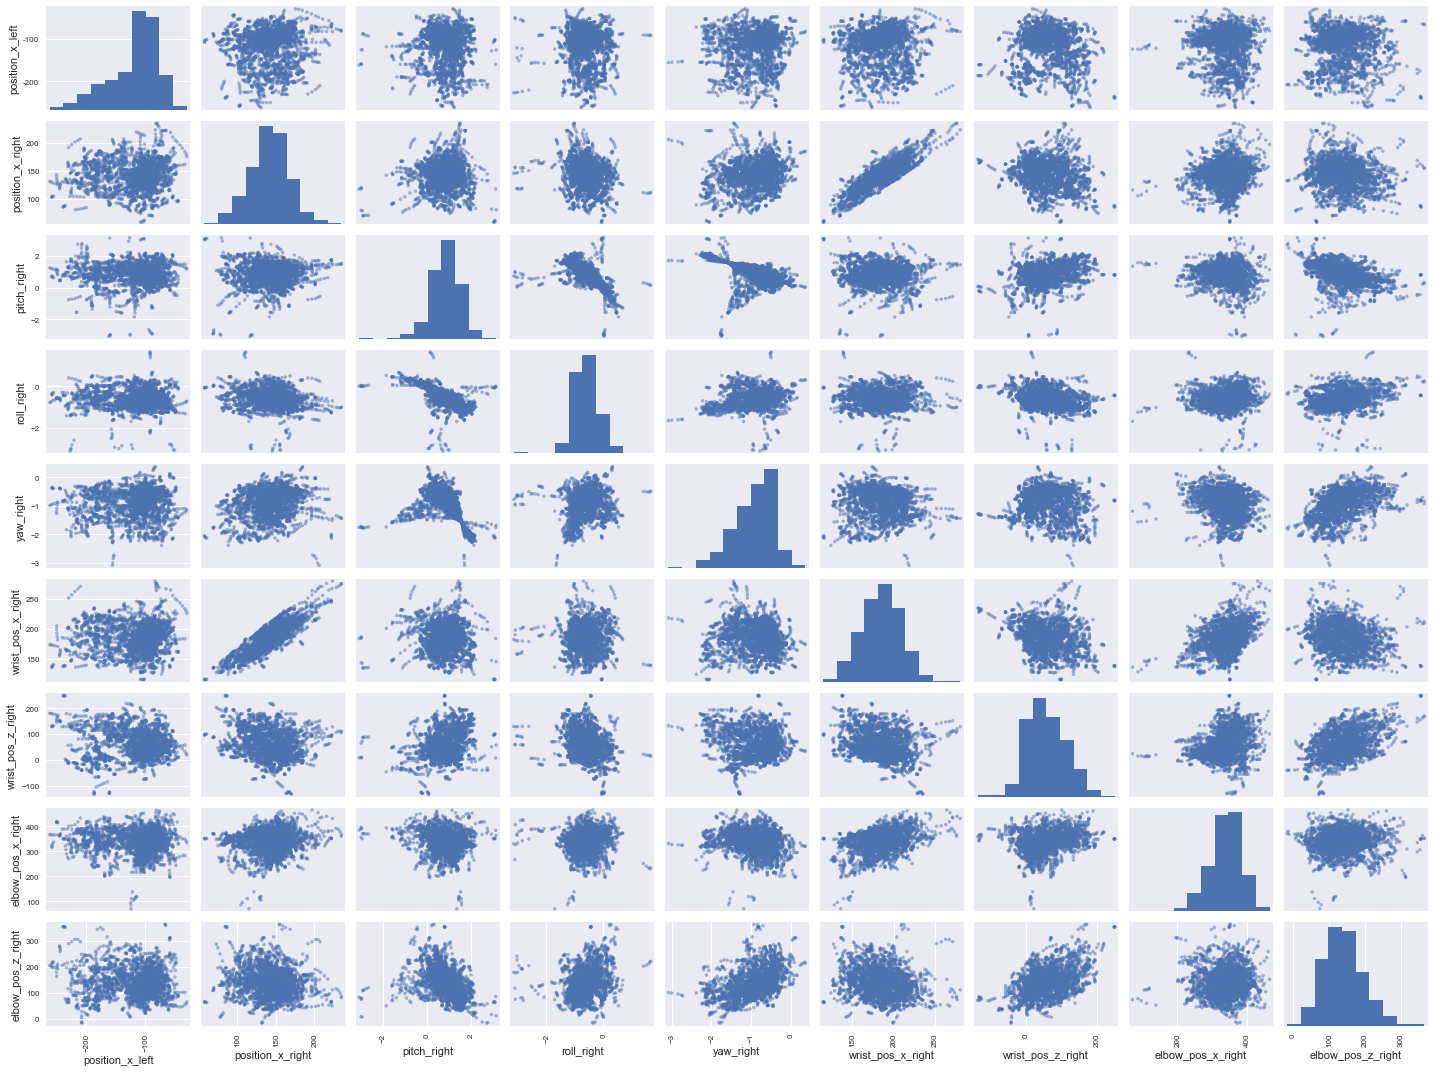

In [71]:
scatter_matrix(state_groups.get_group(1)[cols], figsize=(20, 15))
plt.tight_layout()
plt.show()

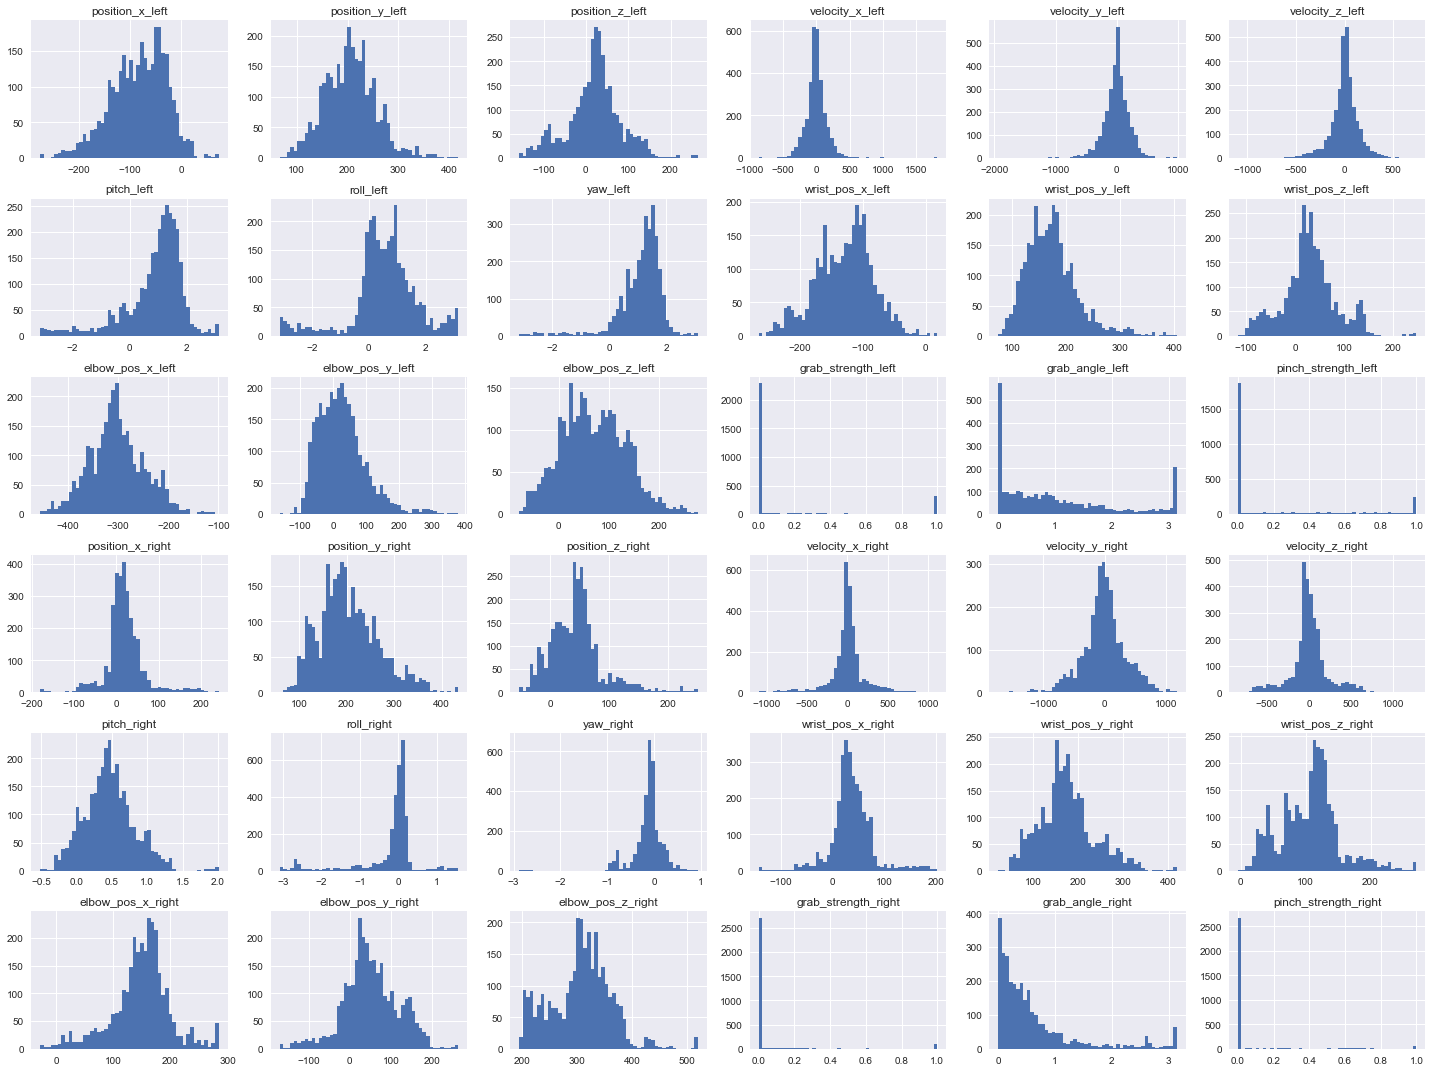

In [35]:
state_groups.get_group(0).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

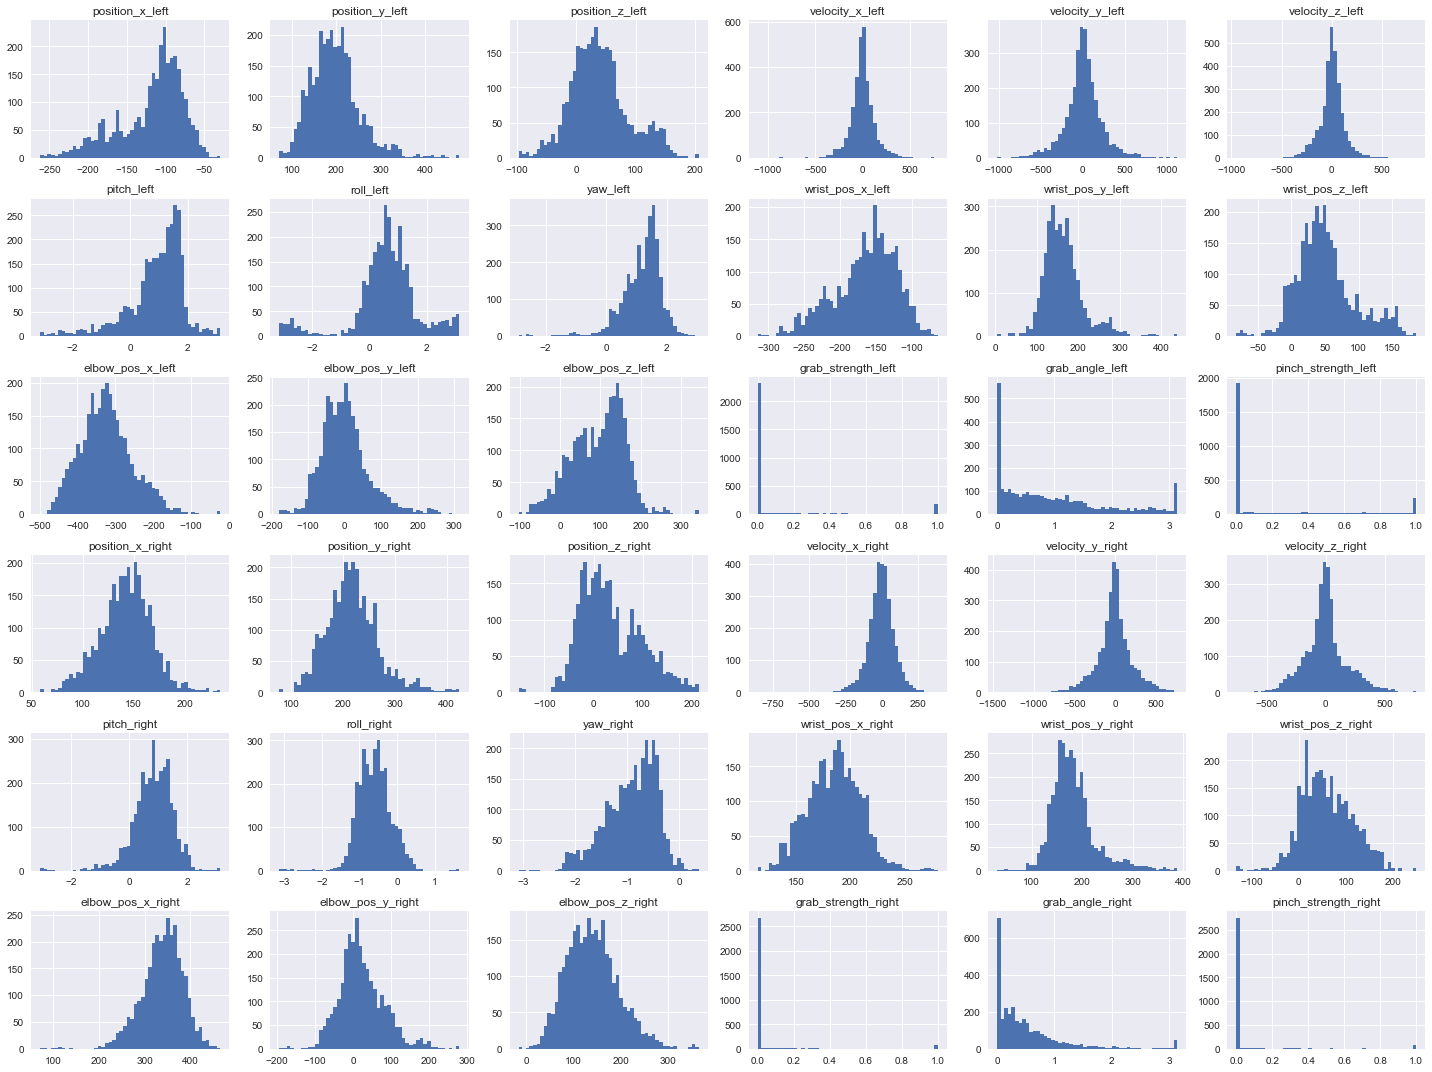

In [36]:
state_groups.get_group(1).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

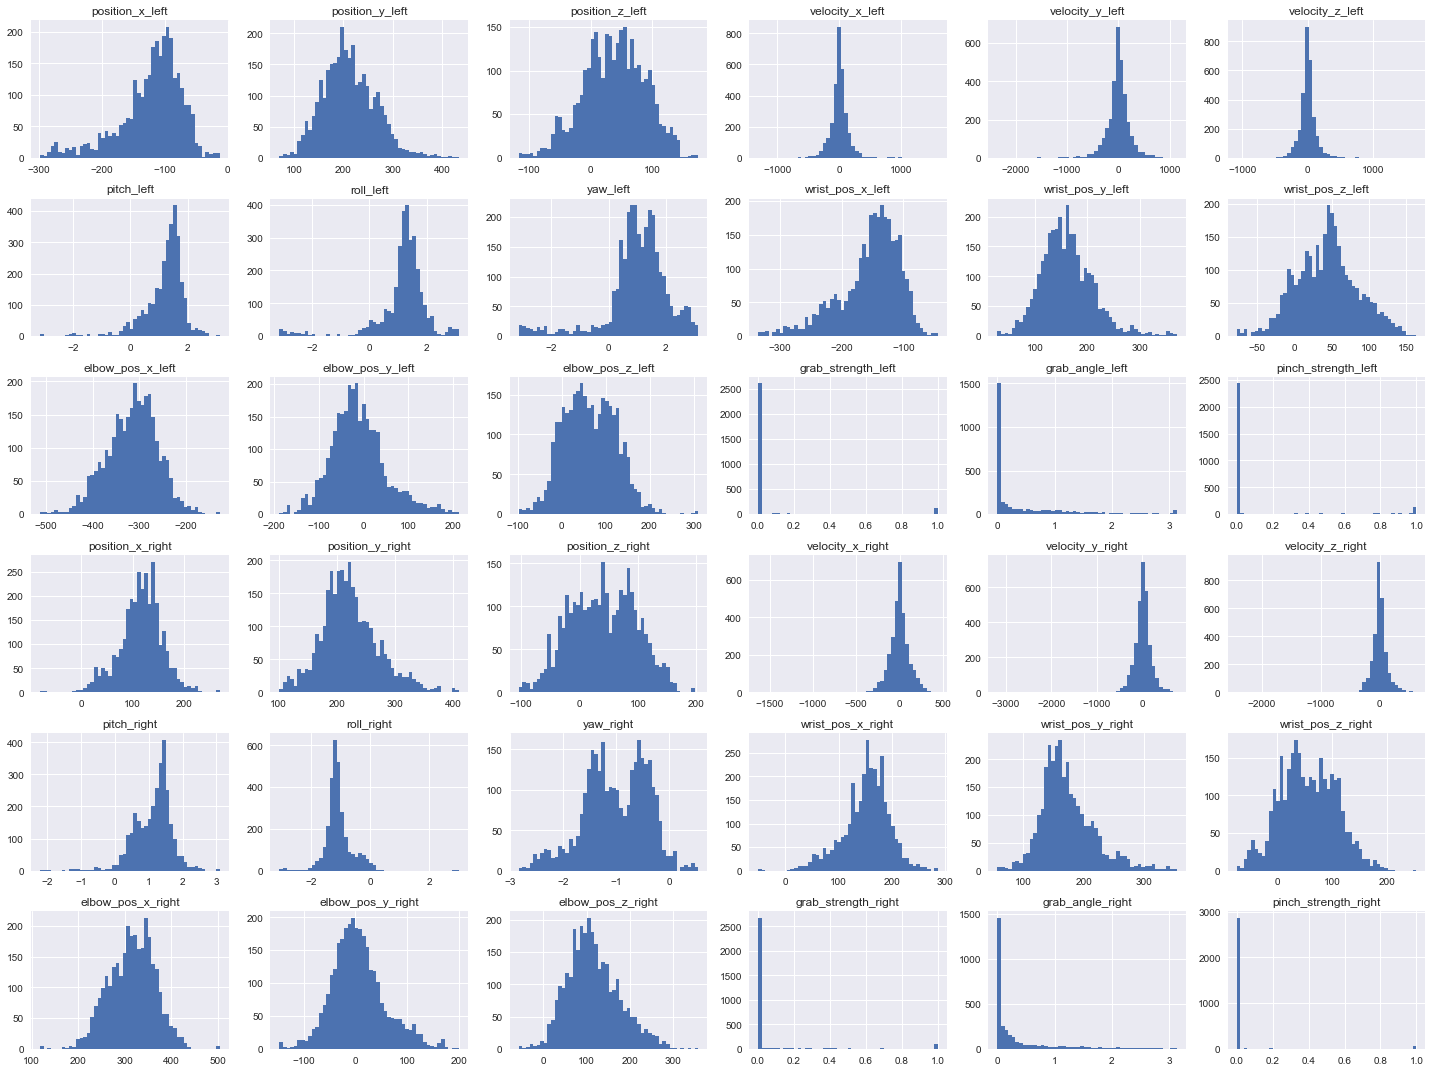

In [37]:
state_groups.get_group(2).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

In [38]:
attributes = {"grab_strength_left", "grab_angle_left", "grab_strength_right", "grab_angle_right"}
hands.drop("time", axis=1, inplace=False).groupby("state").agg(["mean", "std", "min", "max"])[attributes]

grab_angle_left                          grab_angle_right            \
                 mean       std  min       max             mean       std   
state                                                                       
0            1.012939  0.971013  0.0  3.141593         0.614013  0.721209   
1            0.974416  0.923382  0.0  3.141593         0.516066  0.609136   
2            0.518995  0.789772  0.0  3.141593         0.365531  0.621433   

                     grab_strength_left                      \
       min       max               mean       std  min  max   
state                                                         
0      0.0  3.141593           0.158831  0.329375  0.0  1.0   
1      0.0  3.141593           0.133315  0.290989  0.0  1.0   
2      0.0  3.141593           0.081354  0.238060  0.0  1.0   

      grab_strength_right                      
                     mean       std  min  max  
state                                          
0                0.057707  0.205798  0.0  1.0  
1                0.058139  0.199574  0.0  1.0  
2                0.068971  0.220057  0.0  1.0

In [39]:
# hands["pinch_strength_right"].unique()

In [40]:
hands.groupby("state").get_group(0)

state      time  position_x_left  position_y_left  position_z_left  \
685       0  525.8185        -52.96039         184.5535        -2.856696   
686       0  525.8351        -50.04434         185.5024        -4.845364   
687       0  525.8516        -49.07749         182.2930        -6.442950   
688       0  525.8682        -50.89614         176.7708        -9.005262   
689       0  525.8848        -51.76074         174.1853       -10.600340   
...     ...       ...              ...              ...              ...   
8828      0  764.0249       -115.43020         214.5807        29.427190   
8829      0  764.0590       -118.83700         213.6947        28.452710   
8830      0  764.0920       -127.38380         217.6130        27.522990   
8831      0  764.1248       -131.78080         219.9051        27.284910   
8832      0  764.1594       -133.85650         220.8186        25.838900   

      velocity_x_left  velocity_y_left  velocity_z_left  pitch_left  \
685         162.15270       127.605200       -85.837820    1.238877   
686         102.82480       -24.843370       -79.465040    1.244299   
687          12.12360      -258.752600       -99.409020    1.220772   
688         -53.57292      -271.015000      -143.033300    1.096965   
689         -40.95883      -140.443900       -59.856200    1.004597   
...               ...              ...              ...         ...   
8828        -16.33144       -59.822620       -60.437610    1.074734   
8829       -160.69880        -9.069545       -26.648150    1.061467   
8830       -190.01110       147.327800       -33.476150    1.076164   
8831       -153.87100        69.545490        -2.400306    1.104622   
8832        -39.47429        10.012850       -75.146570    1.126323   

      roll_left  yaw_left  wrist_pos_x_left  wrist_pos_y_left  \
685    1.021919  1.199751        -101.04550          132.5940   
686    1.132981  1.171960         -95.51471          131.5824   
687    1.250050  1.152816         -94.32024          128.7403   
688    1.535388  1.114818         -99.72611          127.6519   
689    1.760037  1.091361        -102.66840          128.2257   
...         ...       ...               ...               ...   
8828   1.334178  0.599205        -143.30460          150.4312   
8829   1.381667  0.538450        -144.62540          149.1150   
8830   1.457272  0.383455        -147.49970          151.2106   
8831   1.501699  0.280183        -147.99220          152.0950   
8832   1.518153  0.204644        -147.70900          152.2079   

      wrist_pos_z_left  elbow_pos_x_left  elbow_pos_y_left  elbow_pos_z_left  \
685           4.449887         -307.7127        -12.177800          5.125422   
686           2.853924         -313.0367          3.746006         -0.704697   
687           2.742160         -322.1467         20.402740         -2.617105   
688           5.047988         -331.5826         28.883190         -7.521224   
689           6.734126         -333.9562         27.848030         -3.312394   
...                ...               ...               ...               ...   
8828         52.792060         -270.4008        -70.614750        108.528500   
8829         52.955980         -271.1233        -71.425940        111.958700   
8830         52.308540         -271.3790        -69.055960        117.561100   
8831         50.990430         -265.3397        -70.462820        120.409000   
8832         48.663040         -260.3904        -71.893970        120.792000   

      grab_strength_left  grab_angle_left  pinch_strength_left  \
685             0.000000         0.073635             0.000000   
686             0.000000         0.018766             0.000000   
687             0.000000         0.018409             0.000000   
688             0.000000         0.149852             0.000000   
689             0.000000         0.242324             0.000000   
...                  ...              ...                  ...   
8828            0.000000         0.0

### Notes:

01:37:00

- Organize the data in a pandas dataframe
- Goal: using the hand ... , detect if is alone, sync or spontaneous.
- "spontaneous synchronizing"
- interpersonal space
- training has 9 participants
- validation has different participants
- spontan and sync: if # hands is 1, remove data!
- time series
- every 2 lines is one feature (need to be combined) = 1 frame
- choose how many frames
- position y is similar
- 2 recordings, second is usually better
- can't split train and test as usual (correlation between each following movement). can't shuffle!
for instance, can take first 40 seconds for training and last 5 for testing.
- at least 2 seconds in between train and test
- model for 1 person, try model on second person. train the second person and test the third etc.
- 4 frames per second
-

> #### Resources:
1. Leap Motion Attributes <a href="https://developer-archive.leapmotion.com/documentation/python/api/Leap.Hand.html"
> title="leapmotion">link</a>

In [41]:
# function splits training data into a training set and validations set
# 2 second difference between train and validation

def split_train_val(data):
    train = []
    val = []
    for i in range(len(data)):
        df = data[i]
        train.append(df.drop(df[df["time"] > df["time"].max() - 7].index)) # drop last 7 seconds
        val.append(df.drop(df[df["time"] < df["time"].max() - 5].index)) # append last 5 seconds
    trainX = pd.concat(train, axis=0, ignore_index=True)
    valX = pd.concat(val, axis=0, ignore_index=True)
    return trainX, valX

In [42]:
trainX, valX = split_train_val(load_data(train_path, as_pandas=False))


training_data = []

# glob searches all directories and files
for filename in glob.iglob("extraFiles/Training/**/*.csv", recursive=True):
    df = pd.read_csv(filename, index_col=None, header=0)
    remove_first7(df) # removes first 7 seconds from file
    if "Alone" in filename:
        df = combine_right(df, False)
        df.insert(0, "state", 0)
    elif "Sync" in filename:
        df.insert(0, "state", 1)
    elif "Spontan" in filename:
        df.insert(0, "state", 2)
    df = transform_columns(df)
    training_data.append(df)

# function returns a DataFrame with right and left hands merged into one row
# column names format is changed

def transform_columns2(df):
    # strip removes white spaces in the beginning and end
    # lower changes uppercase letters to lowercase
    df.columns = df.columns.str.strip().str.lower()
    # rename columns without spaces
    df.columns = df.columns.str.replace(" ", "_")
    # change number of hands column name
    df.columns = df.columns.str.replace("#_hands", "n_hands")
    df.columns = df.columns.str.replace("grab_strenth", "grab_strength")

    # remove instances with 1 hand detected
    df.drop(df[df["n_hands"] == 1].index, inplace=True)

    # merge right and left hands into one row
    left = df.groupby("hand_type").get_group("left").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    right = df.groupby("hand_type").get_group("right").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    keep_same = {"state", "time"}  # shared columns
    left.columns = left.columns.map(lambda x: x if x in keep_same else x + "_left")
    right.columns = right.columns.map(lambda x: x if x in keep_same else x + "_right")
    return left.merge(right, how="outer", on=["state", "time"])

# function combines alone csv file with the right hand file

def combine_right2(df_alone, is_test):
    # remove instances with right hand or 2 hands
    df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
    df_alone.reset_index(drop=True, inplace=True)

    # copy of right hand according to train / test
    # prevents harming the DataFrame since it is used multiple times
    if is_test:
        right = handright_prepared_test.copy()
    else:
        right = handright_prepared_train.copy()

    # calculate number of copies needed to match length of left hand
    if len(right) > len(df_alone):
        right = right.loc[:len(df_alone) - 1]  # -1 since loc includes the end index and dataframe indices start from 0
    else:
        df_alone = df_alone.loc[:len(right)-1]
    # align column values with alone
    right.Time = df_alone.Time
    right[" Frame ID"] = df_alone[" Frame ID"]

    # merge DataFrames, sort by Time column and reset index
    merged = right.merge(df_alone, how="outer").sort_values("Time").reset_index(drop=True)
    merged[" # hands"] = 2  # change number of hands to 2 (2 hand rows were dropped per dataframe before merge)
    return merged

# function combines alone csv file with the right hand file

def combine_right(df_alone, is_test):
    # remove instances with right hand or 2 hands
    df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
    df_alone.reset_index(drop=True, inplace=True)

    # copy of right hand according to train / test
    # prevents harming the DataFrame since it is used multiple times
    if is_test:
        right = handright_prepared_test.copy()
    else:
        right = handright_prepared_train.copy()

    # calculate number of copies needed to match length of left hand
    n_copies = round(len(df_alone) / len(right)) + 1
    copies = []  # list for appending copies
    for i in range(n_copies):
        copies.append(right)
    right = pd.concat(copies, axis=0, ignore_index=True)  # concat DataFrame copies
    right = right.loc[:len(df_alone) - 1]  # -1 since loc includes the end index and dataframe indices start from 0

    # align column values with alone
    right.Time = df_alone.Time
    right[" Frame ID"] = df_alone[" Frame ID"]

    # merge DataFrames, sort by Time column and reset index
    merged = right.merge(df_alone, how="outer").sort_values("Time").reset_index(drop=True)
    merged[" # hands"] = 2  # change number of hands to 2 (2 hand rows were dropped per dataframe before merge)
    return merged

alone["Time"] = alone["Time"] - alone["Time"].min()

    # reset index (drop = False) adds round time as the left column in the DataFrame
    df = df.groupby("start_time").nth([0, 1, 2, 3]).reset_index() # first four instances per second

In [43]:
# adds a column with the second
new.insert(1, "round_time", new.time.astype(int) - new.time.min().astype(int))

NameError: name 'new' is not defined

In [ ]:
new

In [ ]:
# round time is the index after groupby
merged = new.groupby("round_time").nth([0, 1, 2, 3, 4]).reset_index(drop=True)

In [ ]:
merged.head(10)

In [ ]:
merged.isna().sum()

In [ ]:
merged

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train = trainX.drop("state", axis=1)
y_train = trainX.state.copy()
X_val = valX.drop("state", axis=1)
y_val = valX.state.copy()

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

In [ ]:
pred = knn.predict(X_val)

In [ ]:
from sklearn import metrics

In [ ]:
print(metrics.classification_report(y_val, pred))